In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing necessary packages**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## **2. Load the Image Training and Validation Datasets**

### i. Get the Image Dataset Paths

In [ ]:
train_dataset_path = '/content/drive/MyDrive/Monkeypox_Skin_Image_Dataset/Train'
validation_dataset_path = '/content/drive/MyDrive/Monkeypox_Skin_Image_Dataset/Test'

### ii. Load Image Datasets and Apply Augmentations
Since the images present in the datasets are 150x150px in size, the image height and width are taken as 150, 150 respectively. The batch size value can be changed if required.

In [ ]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

Loading the training dataset and applying augmentations on it.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 541 images belonging to 4 classes.


Loading the validation dataset.

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 241 images belonging to 4 classes.


### iii. Get the Label Mappings
The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Chickenpox
1 : Measles
2 : Monkeypox
3 : Normal


## **3. Plotting Sample Training Image**s

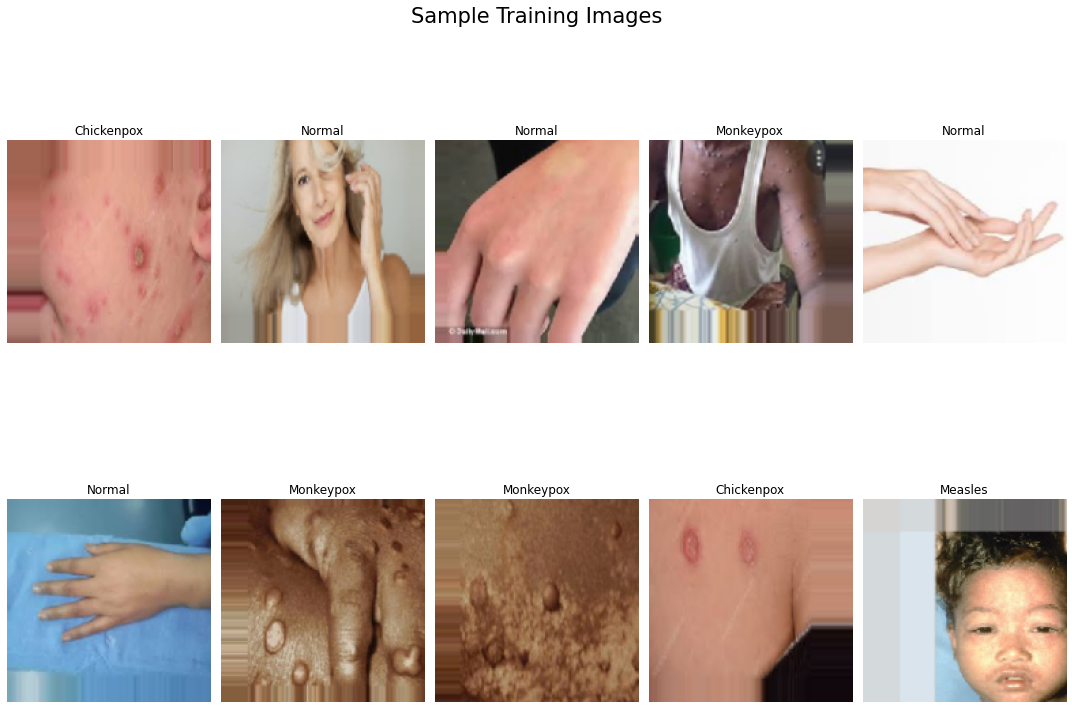

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()
# CLASS_NAMES = ['Chickenpox','Measles','Monkeypoxg','Normal']

## **4. Training a EfficientNetV2M Model**


### i. Create a EfficientNetV2M Model

In [ ]:
base_model = tf.keras.applications.EfficientNetV2M(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(150,150,3),
                     include_preprocessing=True
                     )

base_model.trainable=True

214212608/214201816 [==============================] - 3s 0us/step


In [ ]:
model = tf.keras.Sequential([
        base_model,  
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Functiona  (None, 5, 5, 1280)       53150388  
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 5, 5, 1280)       8960      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

### ii. Defining Callbacks
A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

a. Reduce Learning Rate on Plateau
Is used to reduce the learning rate when a metric has stopped improving.

In [ ]:
!pip install tensorflow_addons
import tensorflow_addons as tfa
METRICS = [
      # tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
      # tf.keras.metrics.Accuracy(name='accuracy'),
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      # tf.keras.metrics.F1Score(name='F1'),
      tfa.metrics.F1Score(num_classes= 4,name="f1_Score")

    
]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.6 MB/s 


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
# early = tf.keras.callbacks.EarlyStopping( patience=10,
#                                           min_delta=0.001,
#                                           restore_best_weights=True)

### iii. Defining the Optimizer

In [ ]:
optimizer = Adam(learning_rate=0.001)

### iv. Compile the Model

In [ ]:
# cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=METRICS)

### v. Training the Model

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=10,
                    validation_data=validation_generator,
                    validation_steps=2,
                    epochs=50,verbose = 2,
                    callbacks=[reduce_lr])

Epoch 1/50
10/10 - 142s - loss: 1.2161 - accuracy: 0.5125 - precision: 0.6462 - recall: 0.2625 - auc: 0.7368 - f1_Score: 0.3463 - val_loss: 1.3402 - val_accuracy: 0.3906 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5852 - val_f1_Score: 0.1404 - lr: 0.0010 - 142s/epoch - 14s/step
Epoch 2/50
10/10 - 38s - loss: 0.9403 - accuracy: 0.6435 - precision: 0.7767 - recall: 0.5047 - auc: 0.8465 - f1_Score: 0.4464 - val_loss: 1.4499 - val_accuracy: 0.2812 - val_precision: 0.4167 - val_recall: 0.1562 - val_auc: 0.5617 - val_f1_Score: 0.1111 - lr: 0.0010 - 38s/epoch - 4s/step
Epoch 3/50
10/10 - 18s - loss: 0.7734 - accuracy: 0.6972 - precision: 0.8190 - recall: 0.5710 - auc: 0.8953 - f1_Score: 0.6040 - val_loss: 1.8954 - val_accuracy: 0.3750 - val_precision: 0.3750 - val_recall: 0.3281 - val_auc: 0.5470 - val_f1_Score: 0.1364 - lr: 0.0010 - 18s/epoch - 2s/step
Epoch 4/50
10/10 - 14s - loss: 0.9023 - accuracy: 0.6719 - precision: 0.7692 - recall: 0.5363 - auc: 0.8825 - f1_Score:

## **5. Plotting the Model Metrics**
### i. Plotting training and validation accuracy, loss and learning rate

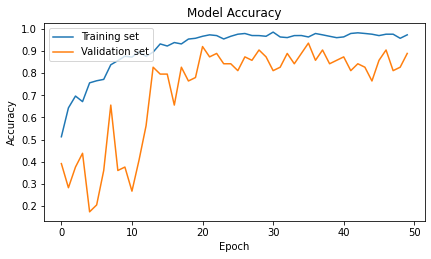

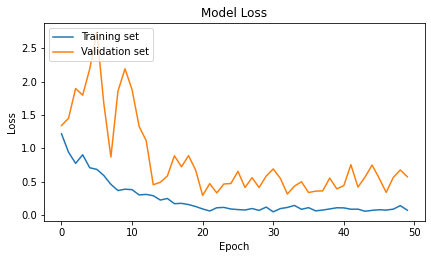

In [ ]:
plt.figure( figsize = (15,8)) 
    
plt.subplot(221)  
# Accuracy 
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()


# Loss
plt.figure( figsize = (15,8)) 
plt.subplot(222)  
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']
# ans = history.history['val_auc']
# ans

[0.5851643681526184,
 0.5617268681526184,
 0.5470377802848816,
 0.6227213144302368,
 0.440511018037796,
 0.3793131411075592,
 0.5854085683822632,
 0.8700764775276184,
 0.5940755605697632,
 0.5518391132354736,
 0.3968098759651184,
 0.6679280996322632,
 0.7949625253677368,
 0.9642741084098816,
 0.9667562246322632,
 0.9448648691177368,
 0.9054362177848816,
 0.9300943613052368,
 0.90966796875,
 0.9438883662223816,
 0.978271484375,
 0.9648845791816711,
 0.9836425185203552,
 0.9691975116729736,
 0.9658203125,
 0.9413248896598816,
 0.9807941913604736,
 0.9664306640625,
 0.97509765625,
 0.9449462294578552,
 0.9476724863052368,
 0.95849609375,
 0.9801431894302368,
 0.9722493290901184,
 0.9681395292282104,
 0.9705811738967896,
 0.9828288555145264,
 0.9795328974723816,
 0.9632974863052368,
 0.97412109375,
 0.9631754159927368,
 0.9298909902572632,
 0.976806640625,
 0.9612630009651184,
 0.9477540254592896,
 0.9742839336395264,
 0.9797770380973816,
 0.9599610567092896,
 0.9426676034927368,
 0.961344

In [ ]:
train_accuracy

0.9907578825950623

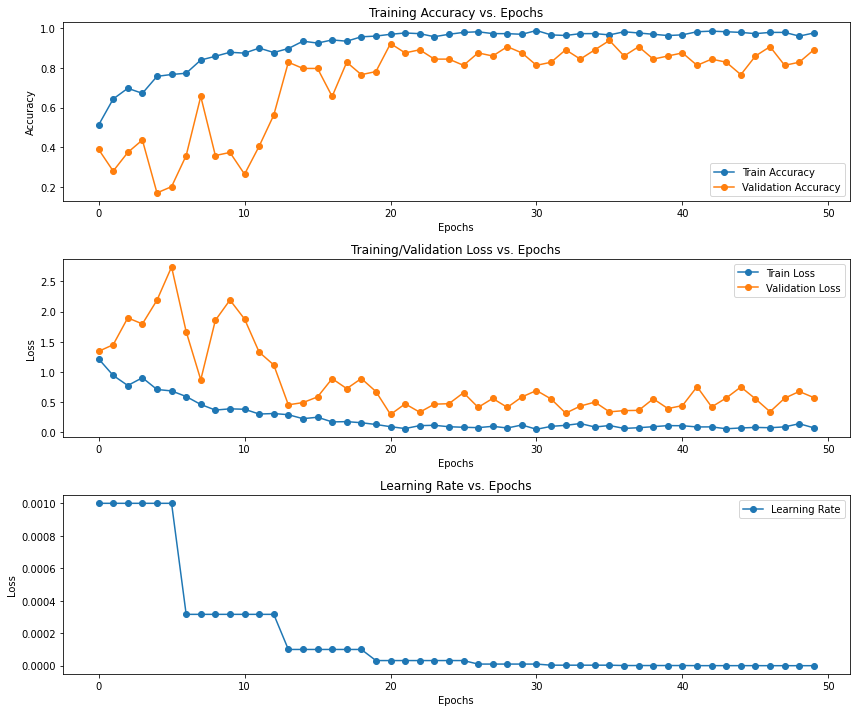

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

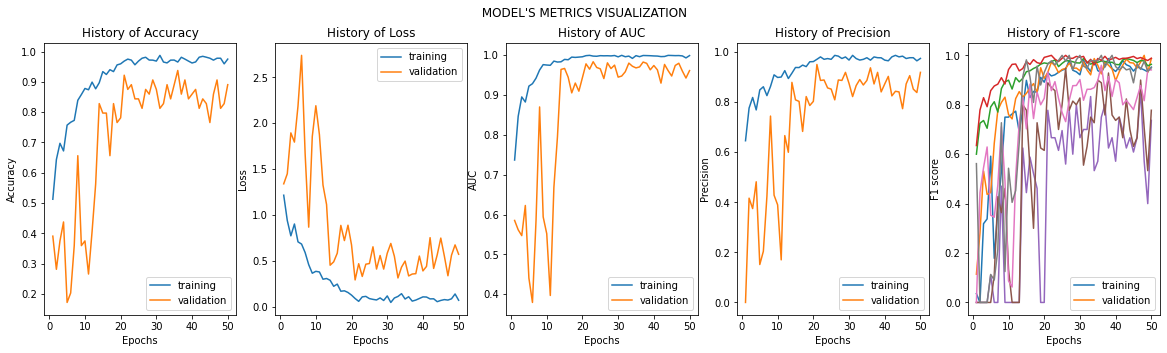

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1_Score,val_f1_Score):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1_Score) + 1), f1_Score)
    ax5.plot(range(1, len(val_f1_Score) + 1), val_f1_Score)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    
import numpy as np
# f1_s= np.mean(history.history['f1_Score'])
# val_f1_s= np.mean(history.history['val_f1_Score'])
Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision']
              #  f1_s,val_f1_s

                , history.history['f1_Score'],history.history['val_f1_Score']
              )


## 6. Testing the Model on Test Set
Testing the model on the validation dataset because a seperate dataset for testing is not available.


In [ ]:
test_dataset = '/content/drive/MyDrive/Monkeypox_Skin_Image_Dataset/Test'

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 241 images belonging to 4 classes.


## 7. Model Prediction on the Test Dataset

In [ ]:
predictions = model.predict(test_generator)

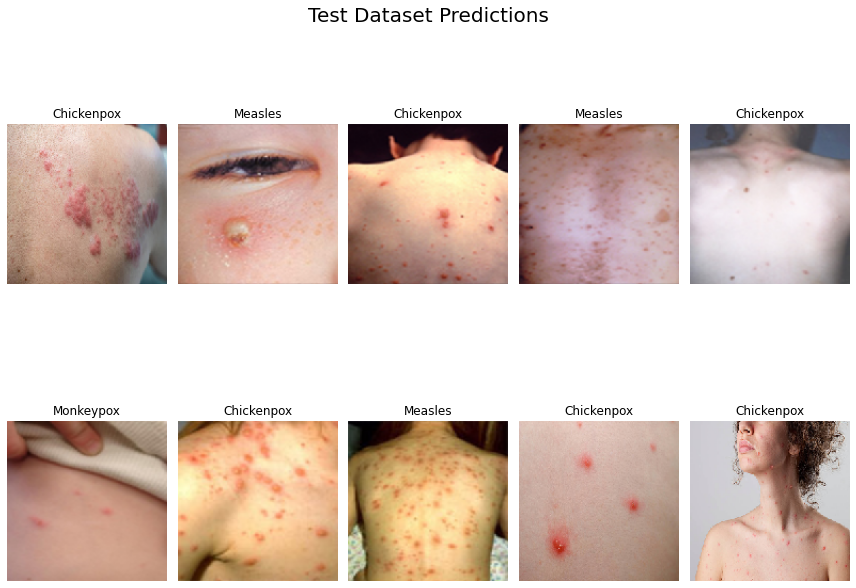

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [ ]:
train_loss, train_accuracy, train_precision, train_recall, train_auc, train_F1_Score = model.evaluate(train_generator, batch_size=BATCH_SIZE)

17/17 [==============================] - 9s 509ms/step - loss: 0.0272 - accuracy: 0.9908 - precision: 0.9907 - recall: 0.9871 - auc: 0.9999 - f1_Score: 0.9890


In [ ]:
print(f"Train Loss:     {train_loss}")
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train AUC: {train_auc}")
print(f"Train F1_Score: {np.mean(train_F1_Score)}")

Train Loss:     0.027172235772013664
Train Accuracy: 0.9907578825950623
Train Precision: 0.9907235503196716
Train Recall: 0.9870610237121582
Train AUC: 0.9999134540557861
Train F1_Score: 0.9890096783638


In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_auc, test_F1_Score = model.evaluate(test_generator, batch_size=BATCH_SIZE)

8/8 [==============================] - 2s 213ms/step - loss: 0.4762 - accuracy: 0.8672 - precision: 0.8809 - recall: 0.8589 - auc: 0.9659 - f1_Score: 0.8313


In [ ]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")
print(f"Test F1_Score: {np.mean(test_F1_Score)}")

Test Loss:     0.4761931002140045
Test Accuracy: 0.8672199249267578
Test Precision: 0.8808510899543762
Test Recall: 0.8589211702346802
Test AUC: 0.9658867120742798
Test F1_Score: 0.8313108682632446


## **8. Plotting the Classification Metrics**
### i. Confusion Matrix

In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

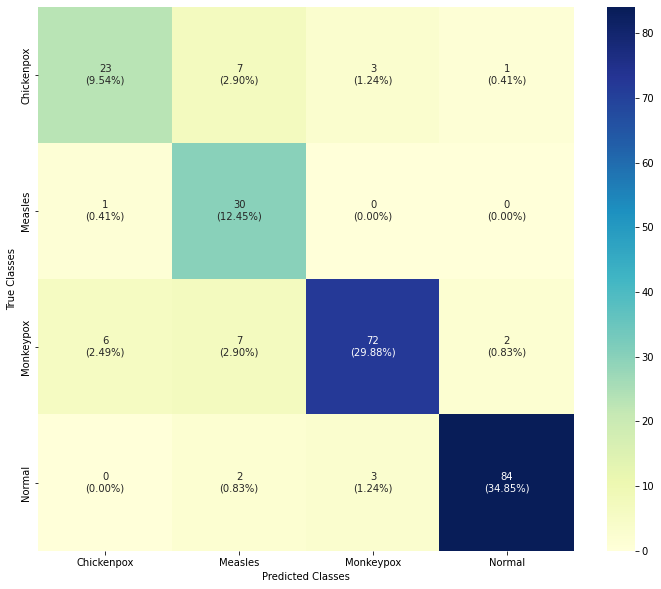

In [ ]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(4, 4)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

  Chickenpox       0.77      0.68      0.72        34
     Measles       0.65      0.97      0.78        31
   Monkeypox       0.92      0.83      0.87        87
      Normal       0.97      0.94      0.95        89

    accuracy                           0.87       241
   macro avg       0.83      0.85      0.83       241
weighted avg       0.88      0.87      0.87       241



In [ ]:
A=history.history['accuracy']
A_v=history.history['val_accuracy']
L=history.history['loss']
L_v=history.history['val_loss']
Auc=history.history['auc']
Auc_v=history.history['val_auc']
P=history.history['precision']
P_v=history.history['val_precision']
F1=history.history['f1_Score']
F1_v=history.history['val_f1_Score']

In [ ]:
import pandas as pd
data_to_submit = pd.DataFrame({
    'accuracy':A,
    'val_accuracy':A_v,
    'loss': L,
    'val_loss': L_v,
    'auc':Auc,
    'val_auc':Auc_v,
    'precision':P,
    'val_precision':P_v,
    'f1_score':F1,
    'val_f1_score':F1_v
})
data_to_submit.to_csv('csv_to_submit.csv', index = False)